In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


![](https://raw.githubusercontent.com/google/deluca-lung/main/assets/2020-10-02%20Ventilator%20diagram.svg)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error as mae

2021-10-31 03:12:34.089155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### As previous versions failed because of my notebook tried to allocate more memory than is available.
> This function helps in reducing memory usage by changing unnecessary data type.

> You could learn more about it [here](https://www.kaggle.com/questions-and-answers/282144)

In [3]:
def reduce_memory_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
data = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
data = reduce_memory_usage(data)
data.head()

Memory usage of dataframe is 368.41 MB
Memory usage after optimization is: 97.86 MB
Decreased by 73.4%


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083313,0,5.835938
1,2,1,20,50,0.033661,18.390625,0,5.906250
2,3,1,20,50,0.067505,22.515625,0,7.875000
3,4,1,20,50,0.101562,22.812500,0,11.742188
4,5,1,20,50,0.135742,25.359375,0,12.234375


## Columns
**id** - globally-unique time step identifier across an entire file

**breath_id** - globally-unique time step for breaths

**R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

**C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
time_step - the actual time stamp.

**u_in** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

**u_out** - the control input for the exploratory solenoid valve. Either 0 or 1.

**pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [5]:
data.shape

(6036000, 8)

In [6]:
data.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

> There is no null value

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int32  
 1   breath_id  int32  
 2   R          int8   
 3   C          int8   
 4   time_step  float16
 5   u_in       float16
 6   u_out      int8   
 7   pressure   float16
dtypes: float16(3), int32(2), int8(3)
memory usage: 97.9 MB


In [8]:
data.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,NaN,NaN,6.204493e-01,NaN
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,0.000000e+00,0.000000e+00,4.852752e-01,0.000000e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895508e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.430664e-01,3.935547e-01,0.000000e+00,6.328125e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308594e+00,4.386719e+00,1.000000e+00,7.031250e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965820e+00,4.984375e+00,1.000000e+00,1.364062e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937500e+00,1.000000e+02,1.000000e+00,6.481250e+01


<AxesSubplot:>

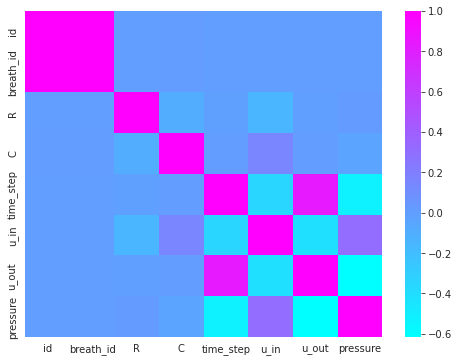

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), cmap='cool')

We can see a strong correaltion between :
> 'pressure' and 'time_step'

> 'pressure' and 'u_out'

## Splitting of categorical and numerical data.

![](https://bookdown.org/ejvanholm/Text-Quant/images/DataTypes.png)

In [10]:
cat_col = []
num_col = []
for i in data.columns:
    if data[i].value_counts().count() > 10:
        num_col.append(i)
    else:
        cat_col.append(i)
print(f'categorical columns: {cat_col}')
print(f'numerical columns: {num_col}')

categorical columns: ['R', 'C', 'u_out']
numerical columns: ['id', 'breath_id', 'time_step', 'u_in', 'pressure']


#### Categorical Data

Text(0.5, 0.98, 'Countplot of Categorical Data')

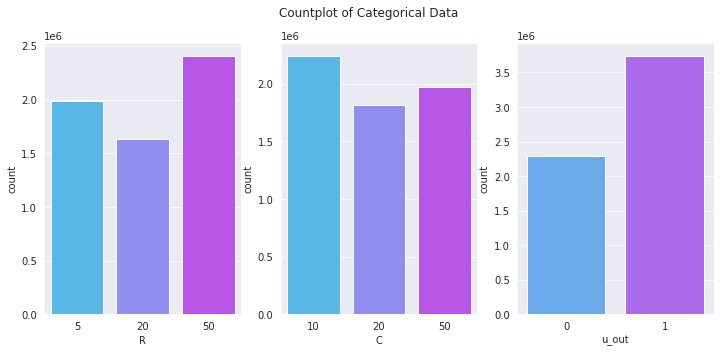

In [11]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
j=0
for i in cat_col:
    sns.countplot(data[i], palette='cool', ax=ax[j])
    j+=1
fig.suptitle('Countplot of Categorical Data')

#### Numerical Data

Removing 'id' and 'breath_id' from numerical column list.

In [12]:
num_col = num_col[2:]
num_col

['time_step', 'u_in', 'pressure']

Text(0.5, 0.98, 'Histplot of Numerical Data')

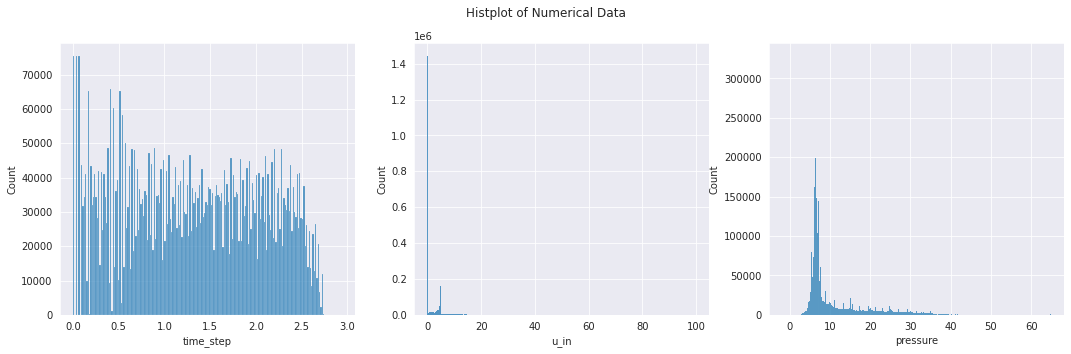

In [13]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
j=0
for i in num_col:
    sns.histplot(data[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Numerical Data')

> I can see a skewness in 'pressure', which is our target variable.

> And, a great outliers in 'u_in' and 'pressure'.

## Outliers
> Let us have a look at outliers now, by using boxplot.

Text(0.5, 0.98, 'Boxplot of Numerical Data')

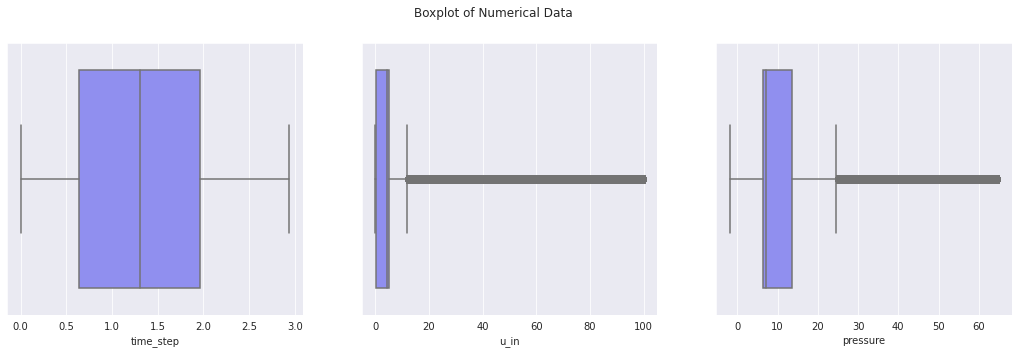

In [14]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
j=0
for i in num_col:
    sns.boxplot(data[i], ax=ax[j], palette='cool')
    j+=1
fig.suptitle('Boxplot of Numerical Data')

> It is always good practice to work with copied dataset. ✓✓

In [15]:
train = data.copy()

## Removing Skewness of target variable.
#### Methods tried :-
1. Log Transformation
2. Log + 1 Transformation
3. Square Root
4. Double Square Root --> This works best.

In [16]:
# fig, ax = plt.subplots(1,2, figsize=(12,5))
# sns.distplot(train['pressure'], ax=ax[0])

# train['pressure'] = np.where(train['pressure'] < 0, 0, train['pressure'])
# train['pressure'] = np.sqrt(np.sqrt(train['pressure']))

# sns.distplot(train['pressure'], ax=ax[1])

## Creating New Features

In [17]:
def create_new_feat(df):
    df["u_in_sum"]         = df.groupby("breath_id")["u_in"].transform("sum")
    df["u_in_std"]         = df.groupby("breath_id")["u_in"].transform("std")
    df["u_in_min"]         = df.groupby("breath_id")["u_in"].transform("min")
    df["u_in_first"]       = df.groupby("breath_id")["u_in"].transform("first")
    df["u_in_last"]        = df.groupby("breath_id")["u_in"].transform("last")
    df["time_passed"]      = df.groupby("breath_id")["time_step"].diff()
    df['area']             = df['time_step'] * df['u_in']
    df['area_2']           = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum']      = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_lag1']        = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1']       = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1']   = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1']  = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2']        = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2']       = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2']   = df.groupby('breath_id')['u_in'].shift(-2) 
    df['u_out_lag_back2']  = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3']        = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3']       = df.groupby('breath_id')['u_out'].shift(3) 
    df['u_in_lag_back3']   = df.groupby('breath_id')['u_in'].shift(-3) 
    df['u_out_lag_back3']  = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4']        = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4']       = df.groupby('breath_id')['u_out'].shift(4) 
    df['u_in_lag_back4']   = df.groupby('breath_id')['u_in'].shift(-4) 
    df['u_out_lag_back4']  = df.groupby('breath_id')['u_out'].shift(-4) 
    
    df = df.fillna(0)
    
    df['breath_id__u_in__diffmax']  = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['cross']                     = df['u_in']*df['u_out']
    df['cross2']                    = df['time_step']*df['u_out']
    df['R']                         = df['R'].astype(str)
    df['C']                         = df['C'].astype(str)
    df['R__C']                      = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
#     df['u_in_lag5']  = df.groupby('breath_id')['u_in'].shift(5)  #
#     df['u_in_lag6']  = df.groupby('breath_id')['u_in'].shift(6)  #
#     df['u_in_lag7']  = df.groupby('breath_id')['u_in'].shift(7)  #
#     df['u_in_lag8']  = df.groupby('breath_id')['u_in'].shift(8)  #
#     df['u_in_lag9']  = df.groupby('breath_id')['u_in'].shift(9)  #
#     df['u_in_lag10'] = df.groupby('breath_id')['u_in'].shift(10) #
#     df['u_in_lag11'] = df.groupby('breath_id')['u_in'].shift(11) #
#     df['u_in_lag12'] = df.groupby('breath_id')['u_in'].shift(12) #
#     df['u_in_lag13'] = df.groupby('breath_id')['u_in'].shift(13) #
#     df['u_in_lag14'] = df.groupby('breath_id')['u_in'].shift(14) #
#     df['u_in_lag15'] = df.groupby('breath_id')['u_in'].shift(15) #
#     df['u_in_lag16'] = df.groupby('breath_id')['u_in'].shift(16) #
#     df['u_in_lag17'] = df.groupby('breath_id')['u_in'].shift(17) #
#     df['u_in_lag18'] = df.groupby('breath_id')['u_in'].shift(18) #
#     df['u_in_lag19'] = df.groupby('breath_id')['u_in'].shift(19) #
#     df['u_in_lag20'] = df.groupby('breath_id')['u_in'].shift(20) #
    df['time_diff']  = (df['time_step']).groupby(df['breath_id']).diff(1)
    df['time_diff2'] = (df['time_step']).groupby(df['breath_id']).diff(2)
    df['time_diff3'] = (df['time_step']).groupby(df['breath_id']).diff(3)
    df['time_diff4'] = (df['time_step']).groupby(df['breath_id']).diff(4)
    df['time_diff5'] = (df['time_step']).groupby(df['breath_id']).diff(5)
    df['time_diff6'] = (df['time_step']).groupby(df['breath_id']).diff(6)
    df['time_diff7'] = (df['time_step']).groupby(df['breath_id']).diff(7)
    df['time_diff8'] = (df['time_step']).groupby(df['breath_id']).diff(8)
    df['u_in_diff1']                = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1']               = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2']                = df['u_in'] - df['u_in_lag2'] 
    df['u_out_diff2']               = df['u_out'] - df['u_out_lag2'] 
    df['u_in_diff3']                = df['u_in'] - df['u_in_lag3'] 
    df['u_out_diff3']               = df['u_out'] - df['u_out_lag3'] 
    df['u_in_diff4']                = df['u_in'] - df['u_in_lag4'] 
    df['u_out_diff4']               = df['u_out'] - df['u_out_lag4'] 
    return df

In [18]:
train = create_new_feat(train)
train = train.fillna(train.min())
train.head()

,id,breath_id,time_step,u_in,u_out,pressure,u_in_sum,u_in_std,u_in_min,u_in_first,u_in_last,time_passed,area,area_2,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__diffmax,breath_id__u_in__diffmean,cross,cross2,R_20,R_5,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50,time_diff,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4
0,1,1,0.000000,0.083313,0,5.835938,811.5,10.124471,0.0,0.083313,4.988281,0.000000,0.000000,0.000000,0.083313,0.000000,0.0,18.390625,0.0,0.000000,0.0,22.515625,0.0,0.000000,0.0,22.812500,0.0,0.000000,0.0,25.359375,0.0,28.234375,10.062500,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.030273,0.062500,0.093750,0.125000,0.15625,0.188477,0.219727,0.251953,0.083313,0.0,0.083313,0.0,0.083313,0.0,0.083313,0.0
1,2,1,0.033661,18.390625,0,5.906250,811.5,10.124471,0.0,0.083313,4.988281,0.033661,0.619141,0.619141,18.468750,0.083313,0.0,22.515625,0.0,0.000000,0.0,22.812500,0.0,0.000000,0.0,25.359375,0.0,0.000000,0.0,27.265625,0.0,9.921875,-8.242188,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.033661,0.062500,0.093750,0.125000,0.15625,0.188477,0.219727,0.251953,18.312500,0.0,18.390625,0.0,18.390625,0.0,18.390625,0.0
2,3,1,0.067505,22.515625,0,7.875000,811.5,10.124471,0.0,0.083313,4.988281,0.033844,1.519531,2.138672,41.000000,18.390625,0.0,22.812500,0.0,0.083313,0.0,25.359375,0.0,0.000000,0.0,27.265625,0.0,0.000000,0.0,27.125000,0.0,5.796875,-12.367188,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.033844,0.067505,0.093750,0.125000,0.15625,0.188477,0.219727,0.251953,4.125000,0.0,22.437500,0.0,22.515625,0.0,22.515625,0.0
3,4,1,0.101562,22.812500,0,11.742188,811.5,10.124471,0.0,0.083313,4.988281,0.034058,2.316406,4.453125,63.812500,22.515625,0.0,25.359375,0.0,18.390625,0.0,27.265625,0.0,0.083313,0.0,27.125000,0.0,0.000000,0.0,26.812500,0.0,5.500000,-12.664062,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.034058,0.067871,0.101562,0.125000,0.15625,0.188477,0.219727,0.251953,0.296875,0.0,4.421875,0.0,22.734375,0.0,22.812500,0.0
4,5,1,0.135742,25.359375,0,12.234375,811.5,10.124471,0.0,0.083313,4.988281,0.034180,3.441406,7.898438,89.187500,22.812500,0.0,27.265625,0.0,22.515625,0.0,27.125000,0.0,18.390625,0.0,26.812500,0.0,0.083313,0.0,27.859375,0.0,2.953125,-15.210938,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.034180,0.068237,0.102051,0.135742,0.15625,0.188477,0.219727,0.251953,2.546875,0.0,2.843750,0.0,6.968750,0.0,25.281250,0.0


In [19]:
train = reduce_memory_usage(train)

Memory usage of dataframe is 1139.76 MB
Memory usage after optimization is: 777.11 MB
Decreased by 31.8%


## Working with Test Data

In [20]:
test_data = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
test_data.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


Text(0.5, 0.98, 'Histplot of Numerical Data')

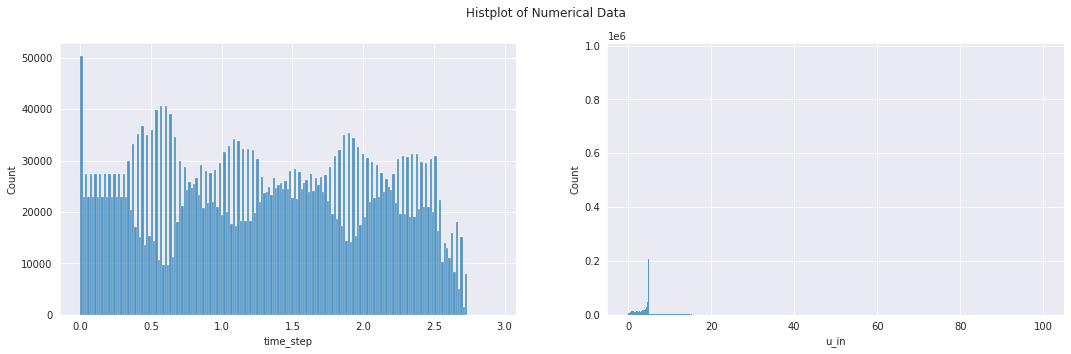

In [21]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
j=0
for i in num_col[:2]:
    sns.histplot(test_data[i], ax=ax[j])
    j+=1
fig.suptitle('Histplot of Numerical Data')

#### Creating New Features

In [22]:
test_data = create_new_feat(test_data)
test_data = test_data.fillna(test_data.min())
test_data.head()

,id,breath_id,time_step,u_in,u_out,u_in_sum,u_in_std,u_in_min,u_in_first,u_in_last,time_passed,area,area_2,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__diffmax,breath_id__u_in__diffmean,cross,cross2,R_20,R_5,R_50,C_10,C_20,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50,time_diff,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4
0,1,0,0.000000,0.000000,0,746.187002,12.179744,0.0,0.0,4.973375,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.515046,0.0,0.000000,0.0,14.651675,0.0,0.000000,0.0,21.230610,0.0,0.0,0.0,26.320956,0.0,37.542219,9.327338,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.031449,0.062907,0.094386,0.125892,0.157406,0.188908,0.220418,0.25193,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,2,0,0.031904,7.515046,0,746.187002,12.179744,0.0,0.0,4.973375,0.031904,0.239758,0.239758,7.515046,0.000000,0.0,14.651675,0.0,0.000000,0.0,21.230610,0.0,0.000000,0.0,26.320956,0.0,0.0,0.0,30.486938,0.0,30.027173,1.812292,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.031904,0.062907,0.094386,0.125892,0.157406,0.188908,0.220418,0.25193,7.515046,0.0,7.515046,0.0,7.515046,0.0,7.515046,0.0
2,3,0,0.063827,14.651675,0,746.187002,12.179744,0.0,0.0,4.973375,0.031924,0.935177,1.174935,22.166721,7.515046,0.0,21.230610,0.0,0.000000,0.0,26.320956,0.0,0.000000,0.0,30.486938,0.0,0.0,0.0,33.545950,0.0,22.890543,-5.324338,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.031924,0.063827,0.094386,0.125892,0.157406,0.188908,0.220418,0.25193,7.136630,0.0,14.651675,0.0,14.651675,0.0,14.651675,0.0
3,4,0,0.095751,21.230610,0,746.187002,12.179744,0.0,0.0,4.973375,0.031924,2.032853,3.207788,43.397331,14.651675,0.0,26.320956,0.0,7.515046,0.0,30.486938,0.0,0.000000,0.0,33.545950,0.0,0.0,0.0,35.717600,0.0,16.311609,-11.903272,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.031924,0.063847,0.095751,0.125892,0.157406,0.188908,0.220418,0.25193,6.578935,0.0,13.715564,0.0,21.230610,0.0,21.230610,0.0
4,5,0,0.127644,26.320956,0,746.187002,12.179744,0.0,0.0,4.973375,0.031893,3.359701,6.567489,69.718287,21.230610,0.0,30.486938,0.0,14.651675,0.0,33.545950,0.0,7.515046,0.0,35.717600,0.0,0.0,0.0,36.971061,0.0,11.221263,-16.993619,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.031893,0.063816,0.095740,0.127644,0.157406,0.188908,0.220418,0.25193,5.090346,0.0,11.669281,0.0,18.805911,0.0,26.320956,0.0


In [23]:
test_data = reduce_memory_usage(test_data)

Memory usage of dataframe is 1592.60 MB
Memory usage after optimization is: 510.40 MB
Decreased by 68.0%


In [24]:
from sklearn.preprocessing import RobustScaler
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
test_data = test_data.drop(['id', 'breath_id'], axis=1)

RS = RobustScaler()
train = RS.fit_transform(train)
test_data = RS.transform(test_data)

train = train.reshape(-1, 80, train.shape[-1])
test_data = test_data.reshape(-1, 80, train.shape[-1])

## Splitting of dependent and independent variable.

In [25]:
idx_len = round(0.90*len(train))
X_train, X_valid = train[0:idx_len], train[idx_len:]
y_train, y_valid = targets[0:idx_len], targets[idx_len:]

## Model

In [26]:
EPOCH = 500
BATCH_SIZE = 256

lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min", restore_best_weights=True)

model = keras.models.Sequential([
keras.layers.Input(shape=train.shape[-2:]),    
keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
keras.layers.Dense(64, activation='selu'),
keras.layers.Dense(1),
])

model.compile(optimizer="adam", loss="mae")

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es])

2021-10-31 03:19:50.590520: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-31 03:19:50.594022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-31 03:19:50.641735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 03:19:50.642342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-31 03:19:50.642428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-31 03:19:50.670196: I tensorflow/stream_executor/platform/def

Epoch 1/500


2021-10-31 03:20:07.422039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-31 03:20:08.223896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-31 03:20:08.275236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


266/266 [==============================] - 149s 506ms/step - loss: 2.3946 - val_loss: 0.5925
Epoch 2/500
266/266 [==============================] - 132s 494ms/step - loss: 0.5566 - val_loss: 0.5101
Epoch 3/500
266/266 [==============================] - 131s 494ms/step - loss: 0.4808 - val_loss: 0.4365
Epoch 4/500
266/266 [==============================] - 131s 494ms/step - loss: 0.4285 - val_loss: 0.3884
Epoch 5/500
266/266 [==============================] - 132s 495ms/step - loss: 0.3952 - val_loss: 0.4171
Epoch 6/500
266/266 [==============================] - 132s 495ms/step - loss: 0.3758 - val_loss: 0.3553
Epoch 7/500
266/266 [==============================] - 131s 494ms/step - loss: 0.3427 - val_loss: 0.3529
Epoch 8/500
266/266 [==============================] - 132s 495ms/step - loss: 0.3311 - val_loss: 0.3335
Epoch 9/500
266/266 [==============================] - 132s 495ms/step - loss: 0.3505 - val_loss: 0.3602
Epoch 10/500
266/266 [==============================] - 132s 495ms/

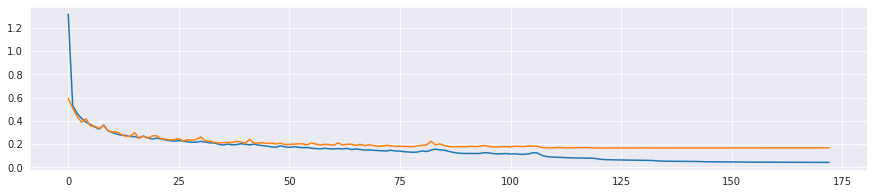

In [27]:
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Prediction

In [28]:
pred = model.predict(test_data, batch_size=BATCH_SIZE)

2021-10-31 09:41:11.949040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1014048000 exceeds 10% of free system memory.


In [29]:
# sample = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
# sample['id'] = test_data['id']
# sample['pressure'] = pd.DataFrame({'pressure': pred[:]})
# sample.head()

In [30]:
sample = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
sample['pressure'] = pred.squeeze().reshape(-1, 1).squeeze()

q1 = sample['pressure'].quantile(0.001)
q2 = sample['pressure'].quantile(0.999)
sample['pressure'] = sample['pressure'].apply(lambda x: x if x>q1 else x*0.77)
sample['pressure'] = sample['pressure'].apply(lambda x: x if x<q2 else x*1.1)
sample.to_csv('submission_LSTM.csv', index=False)

## Thank you!!!
## Hope you enjoyed this notebook. 😊